# **Vehicle Plate License Detection (HumAIn 2019)**

**Part-1: License Plate Localization**

In [1]:
# This cell imports the drive library and mounts your Google Drive as a VM local drive. You can access to your Drive files 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from PIL import Image
import glob
import imutils

In [28]:
# CUDA: Let's check that Nvidia CUDA is already pre-installed and which version is it.
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [2]:
!cat /content/gdrive/My\ Drive/darknet/cuDNN/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

#define CUDNN_MAJOR 7
#define CUDNN_MINOR 5
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


In [3]:
# Leave this code uncommented on the very first run of your notebook or if you ever need to recompile darknet again.
# Comment this code on the future runs.
!git clone https://github.com/kriyeng/darknet/
%cd darknet

# Check the folder
!ls

# I have a branch where I have done the changes commented above
!git checkout feature/google-colab

#Compile Darknet
!make

#Copies the Darknet compiled version to Google drive
!cp ./darknet /content/gdrive/My\ Drive/darknet/bin/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 10068, done.
remote: Total 10068 (delta 0), reused 0 (delta 0), pack-reused 10068
Receiving objects: 100% (10068/10068), 9.97 MiB | 8.93 MiB/s, done.
Resolving deltas: 100% (6769/6769), done.
/content/darknet
3rdparty      CMakeLists.txt	      image_yolov3.sh	     scripts
appveyor.yml  CMakeSettings.json      include		     src
build	      DarknetConfig.cmake.in  json_mjpeg_streams.sh  video_v2.sh
build.ps1     darknet.py	      LICENSE		     video_yolov3.sh
build.sh      darknet_video.py	      Makefile
cfg	      data		      net_cam_v3.sh
cmake	      image_yolov2.sh	      README.md
Branch 'feature/google-colab' set up to track remote branch 'feature/google-colab' from 'origin'.
Switched to a new branch 'feature/google-colab'
mkdir -p obj
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wn

In [0]:
#download files
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)
def download(path):
  from google.colab import files
  files.download(path)

layer     filters    size              input                output
   0 conv     16  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  16 0.150 BF
   1 max          2 x 2 / 2   416 x 416 x  16   ->   208 x 208 x  16 0.003 BF
   2 conv     32  3 x 3 / 1   208 x 208 x  16   ->   208 x 208 x  32 0.399 BF
   3 max          2 x 2 / 2   208 x 208 x  32   ->   104 x 104 x  32 0.001 BF
   4 conv     64  3 x 3 / 1   104 x 104 x  32   ->   104 x 104 x  64 0.399 BF
   5 max          2 x 2 / 2   104 x 104 x  64   ->    52 x  52 x  64 0.001 BF
   6 conv    128  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x 128 0.399 BF
   7 max          2 x 2 / 2    52 x  52 x 128   ->    26 x  26 x 128 0.000 BF
   8 conv    256  3 x 3 / 1    26 x  26 x 128   ->    26 x  26 x 256 0.399 BF
   9 max          2 x 2 / 2    26 x  26 x 256   ->    13 x  13 x 256 0.000 BF
  10 conv    512  3 x 3 / 1    13 x  13 x 256   ->    13 x  13 x 512 0.399 BF
  11 max          2 x 2 / 1    13 x  13 x 512   ->    13 x  13 x 512 0.000 

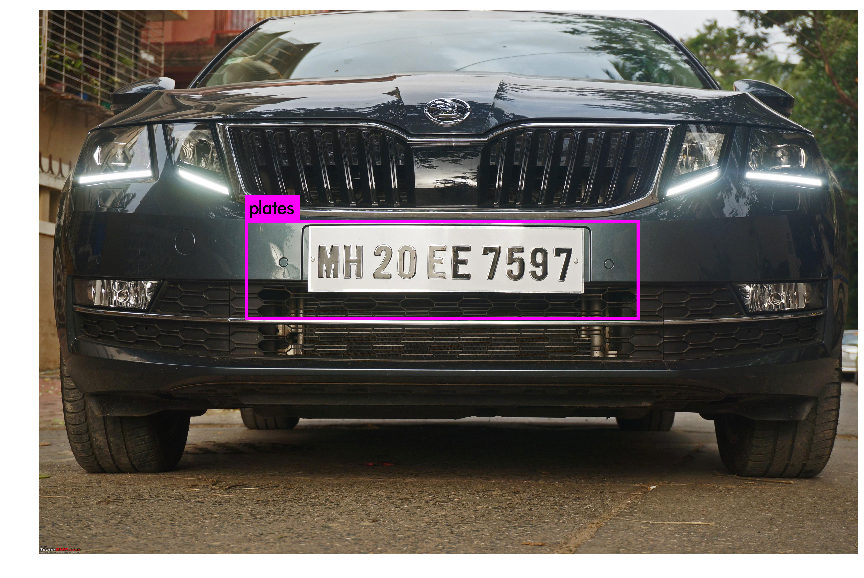

In [11]:
# Not necessary cell
# Execute darknet using YOLOv3 model with pre-trained weights to detect objects on 'person.jpg'
!./darknet detector test /content/gdrive/My\ Drive/darknet/obj.data /content/gdrive/My\ Drive/darknet/cfg/yolov3-LD.cfg /content/gdrive/My\ Drive/darknet/weights/license_detect.weights /content/gdrive/My\ Drive/darknet/test/car34.jpg -dont-show -ext_output "/content/gdrive/My Drive/darknet/img.txt" "/content/gdrive/My Drive/darknet/result.txt"

# Show the result using the helper imgShow()
imShow('predictions.jpg')

In [0]:
bb = open('/content/gdrive/My Drive/darknet/result.txt','r')
bb = bb.readlines()
bb = [int(x) for x in bb[0].split()]
x_point_top = bb[0]
y_point_top = bb[1]
x_point_bot = bb[0]+bb[2]
y_point_bot = bb[1]+bb[3]

In [0]:
img_path="/content/gdrive/My Drive/darknet/test/car34.jpg"

In [0]:
img = Image.open(img_path)
lp = img.crop((x_point_top, y_point_top, x_point_bot, y_point_bot))
lp.save('/content/gdrive/My Drive/lstmocr/test/lp34.jpg')

**Part-2: License Text Detection**

In [65]:
import keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)

Using TensorFlow backend.


TensorFlow version: 1.14.0
Keras version: 2.2.5


In [0]:
import os
from os.path import join
import json
import random
import itertools
import re
import datetime
#import cairocffi as cairo
#import editdistance
import numpy as np
from scipy import ndimage
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import keras.callbacks
import cv2

In [0]:
sess = tf.Session()
K.set_session(sess)

In [70]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Loaded model from disk


In [0]:
def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

def is_valid_str(s):
    for ch in s:
        if not ch in letters:
            return False
    return True

class TextImageGenerator:
    
    def __init__(self, 
                 dirpath,
                 tag,
                 img_w, img_h, 
                 batch_size, 
                 downsample_factor,
                 max_text_len=12):
        
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.downsample_factor = downsample_factor
        
        img_dirpath = join(dirpath, 'img')
        ann_dirpath = join(dirpath, 'ann')
        self.samples = []
        for filename in os.listdir(img_dirpath):
            name, ext = os.path.splitext(filename)
            if ext in ['.png', '.jpg']:
                img_filepath = join(img_dirpath, filename)
                json_filepath = join(ann_dirpath, name + '.png.json')
                ann = json.load(open(json_filepath, 'r'))
                description = ann['description']
                tags = ann['tags']
                #print(tags[0]['name'])
                if tag not in tags[0]['name']:
                    #print(tags[0]['name'])
                    continue
                if is_valid_str(description):
                    self.samples.append([img_filepath, description])
                    #print(self.samples)
        
        self.n = len(self.samples)
        #print(self.samples)
        #print(self.n)
        self.indexes = list(range(self.n))
        self.cur_index = 0
        
    def build_data(self):
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        for i, (img_filepath, text) in enumerate(self.samples):
            img = cv2.imread(img_filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img.astype(np.float32)
            img /= 255
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            self.imgs[i, :, :] = img
            self.texts.append(text)
        #print(self.texts)
        
    def get_output_size(self):
        return len(letters) + 1
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]
    
    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            if K.image_data_format() == 'channels_first':
                X_data = np.ones([self.batch_size, 1, self.img_w, self.img_h])
            else:
                X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.ones([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            source_str = []
                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                text = "{:<12}".format(text)  #Right Side Padding, Try Centre Padding
                if K.image_data_format() == 'channels_first':
                    img = np.expand_dims(img, 0)
                else:
                    img = np.expand_dims(img, -1)
                X_data[i] = img
                #print(text)
                Y_data[i] = text_to_labels(text)
                source_str.append(text)
                label_length[i] = len(text)
                
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
                #'source_str': source_str
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

In [0]:
# For a real OCR application, this should be beam search with a dictionary
# and language model.  For this example, best path is sufficient.
letters = [' ','0', '1', '2', '3', '4', '5', '6', '7', '8', '9' ,
           'A', 'B', 'C', 'D' ,'E', 'F', 'G' ,'H' ,'I' ,'J', 'K', 'L', 'M', 'N' ,'O', 'P', 'Q', 'R', 'S', 'T', 
           'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'd', 'i', 'p']

def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters):
                outstr += letters[c]
        ret.append(outstr)
    return ret

Predicted: MH20EE7597
True: MH20EE7597  


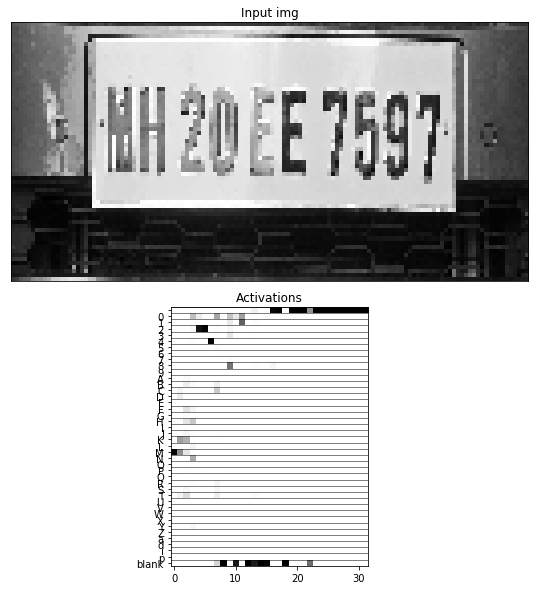

In [76]:
img_fm = TextImageGenerator('./test', 'train', 128, 64, 1, 4)
img_fm.build_data()

net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

for inp_value, _ in img_fm.next_batch():
    bs = inp_value['the_input'].shape[0]
    X_data = inp_value['the_input']
    net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    pred_texts = decode_batch(net_out_value)
    labels = inp_value['the_labels']
    texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: letters[int(x)], label)))
        texts.append(text)
    
    for i in range(bs):
        fig = plt.figure(figsize=(10, 10))
        outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
        ax1 = plt.Subplot(fig, outer[0])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, outer[1])
        fig.add_subplot(ax2)
        print('Predicted: %s\nTrue: %s' % (pred_texts[i] , texts[i]))
        img = X_data[i][:, :, 0].T
        ax1.set_title('Input img')
        ax1.imshow(img, cmap='gray')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_title('Activations')
        ax2.imshow(net_out_value[i].T, cmap='binary', interpolation='nearest')
        ax2.set_yticks(list(range(len(letters) + 1)))
        ax2.set_yticklabels(letters + ['blank'])
        ax2.grid(False)
        for h in np.arange(-0.5, len(letters) + 1 + 0.5, 1):
            ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)
        
        #ax.axvline(x, linestyle='--', color='k')
        plt.show()
    break